# Pandas and Seaborn

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
from pathlib import Path
import pandas as pd
import zipfile

plt.style.use('fivethirtyeight')
sns.set_context("notebook")

## Getting the Data

https://www.ssa.gov/OACT/babynames/index.html

https://www.ssa.gov/data

We can download data from the internet with Python, and do so only if needed:

In [4]:
namesbystate_path = Path('namesbystate.zip')
data_url = 'https://www.ssa.gov/oact/babynames/state/namesbystate.zip'

if not namesbystate_path.exists():
    print('Downloading...', end=' ')
    resp = requests.get(data_url)
    with namesbystate_path.open('wb') as f:
        f.write(resp.content)
    print('Done!')

## What were the most popular New York male & female names in each year?

### Extracting from a ZIP archive

We can see how large the compressed and uncompressed data are:

In [7]:
zf = zipfile.ZipFile(namesbystate_path, 'r')
sum(f.file_size for f in zf.filelist) / 1_000_000

122.38892

In [8]:
sum(f.compress_size for f in zf.filelist) / 1_000_000

21.568281

In [9]:
__/_  # divide the next-previous result by the previous one

5.674486529547719

What are these data?

In [10]:
zf.extract('StateReadMe.pdf')

'C:\\Users\\policast\\Documents\\Teaching\\Fall-2019\\DS-UA-112\\lectures\\lec08\\demo\\plot\\StateReadMe.pdf'

We want the names for New York.

In [12]:
print([f.filename for f in zf.filelist])

['AK.TXT', 'AL.TXT', 'AR.TXT', 'AZ.TXT', 'CA.TXT', 'CO.TXT', 'CT.TXT', 'DC.TXT', 'DE.TXT', 'FL.TXT', 'GA.TXT', 'HI.TXT', 'IA.TXT', 'ID.TXT', 'IL.TXT', 'IN.TXT', 'KS.TXT', 'KY.TXT', 'LA.TXT', 'MA.TXT', 'MD.TXT', 'ME.TXT', 'MI.TXT', 'MN.TXT', 'MO.TXT', 'MS.TXT', 'MT.TXT', 'NC.TXT', 'ND.TXT', 'NE.TXT', 'NH.TXT', 'NJ.TXT', 'NM.TXT', 'NV.TXT', 'NY.TXT', 'OH.TXT', 'OK.TXT', 'OR.TXT', 'PA.TXT', 'RI.TXT', 'SC.TXT', 'SD.TXT', 'StateReadMe.pdf', 'TN.TXT', 'TX.TXT', 'UT.TXT', 'VA.TXT', 'VT.TXT', 'WA.TXT', 'WI.TXT', 'WV.TXT', 'WY.TXT']


In [15]:
ny_name = 'NY.TXT'
with zf.open(ny_name) as f:
    for i in range(10):
        print(f.readline().rstrip().decode())

NY,F,1910,Mary,1923
NY,F,1910,Helen,1290
NY,F,1910,Rose,990
NY,F,1910,Anna,951
NY,F,1910,Margaret,926
NY,F,1910,Dorothy,897
NY,F,1910,Ruth,713
NY,F,1910,Lillian,648
NY,F,1910,Florence,604
NY,F,1910,Frances,589


In [16]:
field_names = ['State', 'Sex', 'Year', 'Name', 'Count']
with zf.open(ny_name) as fh:
    ny = pd.read_csv(fh, header=None, names=field_names)
ny.head()

,State,Sex,Year,Name,Count
0,NY,F,1910,Mary,1923
1,NY,F,1910,Helen,1290
2,NY,F,1910,Rose,990
3,NY,F,1910,Anna,951
4,NY,F,1910,Margaret,926


In [17]:
ny.shape

(291657, 5)

### Group by year

In [18]:
ny[(ny['Year'] == 1995) & (ny['Sex'] == 'M')].head()

,State,Sex,Year,Name,Count
246336,NY,M,1995,Michael,3910
246337,NY,M,1995,Christopher,2900
246338,NY,M,1995,Matthew,2744
246339,NY,M,1995,Nicholas,2663
246340,NY,M,1995,Joseph,2470


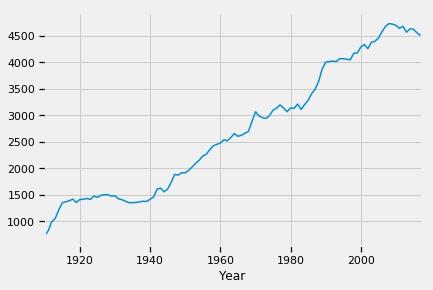

In [23]:
ny.groupby('Year').size().plot();

### Grouping by multiple columns

In [24]:
ny.groupby(['Year', 'Sex']).size().head()

Year  Sex
1910  F      451
      M      280
1911  F      463
      M      361
1912  F      534
dtype: int64

In [25]:
ny.groupby(['Year', 'Sex']).size().head()

Year  Sex
1910  F      451
      M      280
1911  F      463
      M      361
1912  F      534
dtype: int64

In [26]:
most_popular_names = (ny.groupby(['Year', 'Sex']).first())
most_popular_names.head()

State  Name  Count
Year Sex                   
1910 F      NY  Mary   1923
     M      NY  John   1125
1911 F      NY  Mary   2322
     M      NY  John   1624
1912 F      NY  Mary   2909

As we'd expect, we get a MultiIndexed DataFrame, which we can index using [] just like our single indexed DataFrames.

In [27]:
most_popular_names[most_popular_names['Name'] == 'John']

,,State,Name,Count
Year,Sex,,,
1910,M,NY,John,1125
1911,M,NY,John,1624
1912,M,NY,John,2708
1913,M,NY,John,3149
1914,M,NY,John,4289
1915,M,NY,John,5180
1916,M,NY,John,5370
1917,M,NY,John,5759
1918,M,NY,John,6058


`.loc` is a bit more complicated:

In [28]:
most_popular_names.loc[2017, :, :]

State    Name  Count
Year Sex                     
2017 F      NY  Olivia   1227
     M      NY    Liam   1427

In [29]:
pop_pivot = ny.pivot_table(
    index='Sex',
    columns='Year',
    values='Name',
    aggfunc=lambda ns: ns.iloc[0]
)
pop_pivot

Year,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Sex,,,,,,,,,,,,,,,,,,,,,
F,Mary,Mary,Mary,Mary,Mary,Mary,Mary,Mary,Mary,Mary,...,Isabella,Isabella,Isabella,Sophia,Sophia,Sophia,Sophia,Olivia,Olivia,Olivia
M,John,John,John,John,John,John,John,John,John,John,...,Michael,Michael,Michael,Michael,Michael,Jacob,Jacob,Liam,Liam,Liam


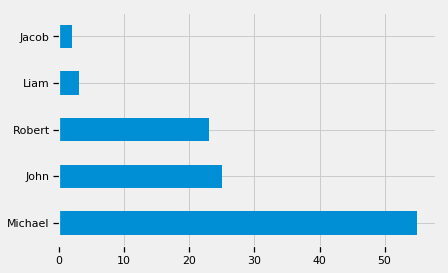

In [30]:
pop_pivot.loc['M'].value_counts().plot(kind='barh');

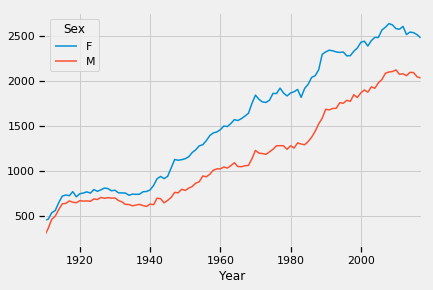

In [31]:
ny.pivot_table(
    index='Year',
    columns='Sex',
    values='Name',
    aggfunc=len,
).plot();

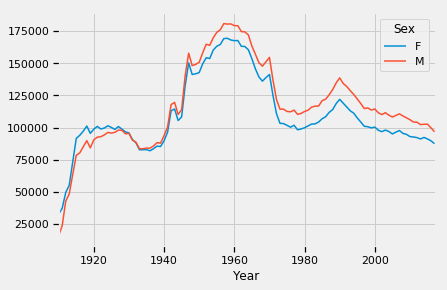

In [32]:
ny.pivot_table(
    index='Year',
    columns='Sex',
    values='Count',
    aggfunc=sum,
).plot();

## Can you deduce birth sex from the last letter of a person’s name?

### Compute last letter of each name

In [33]:
ny.head()

,State,Sex,Year,Name,Count
0,NY,F,1910,Mary,1923
1,NY,F,1910,Helen,1290
2,NY,F,1910,Rose,990
3,NY,F,1910,Anna,951
4,NY,F,1910,Margaret,926


In [34]:
ny['Name'].str[-1].head()

0    y
1    n
2    e
3    a
4    t
Name: Name, dtype: object

To add column to dataframe:

In [35]:
ny['Last'] = ny['Name'].str[-1]
ny.head()

,State,Sex,Year,Name,Count,Last
0,NY,F,1910,Mary,1923,y
1,NY,F,1910,Helen,1290,n
2,NY,F,1910,Rose,990,e
3,NY,F,1910,Anna,951,a
4,NY,F,1910,Margaret,926,t


### Group by last letter and sex

In [38]:
letter_counts = (ny
                 .loc[:, ('Sex', 'Count', 'Last')]
                 .groupby(['Last', 'Sex'])
                 .sum())
letter_counts.head()

Count
Last Sex         
a    F    3902939
     M     110143
b    F       1271
     M      62620
c    F        962

### Visualize our result

Use .plot to get some basic plotting functionality:

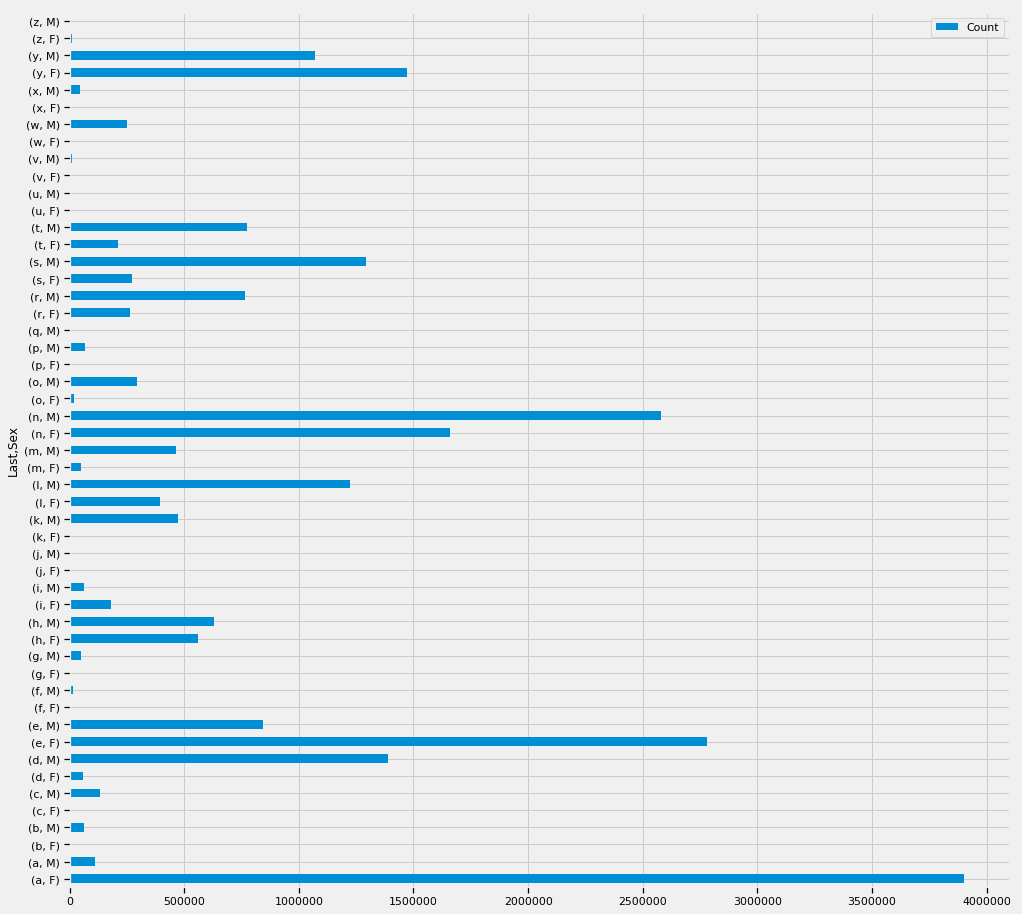

In [37]:
# Why is this not good?
letter_counts.plot.barh(figsize=(15, 15));

Reading the docs shows me that pandas will make one set of bars for each column in my table. How do I move each sex into its own column? I have to use pivot:

In [40]:
# For comparison, the group above:
# letter_counts = (ny
#                  .loc[:, ('Sex', 'Count', 'Last')]
#                  .groupby(['Last', 'Sex'])
#                  .sum())

last_letter_pivot = ny.pivot_table(
    index='Last', # the rows (turned into index)
    columns='Sex', # the column values
    values='Count', # the field(s) to processed in each group
    aggfunc=sum, # group operation
)
last_letter_pivot.head()

Sex,F,M
Last,,
a,3902939.0,110143.0
b,1271.0,62620.0
c,962.0,131376.0
d,59145.0,1389247.0
e,2779252.0,845460.0


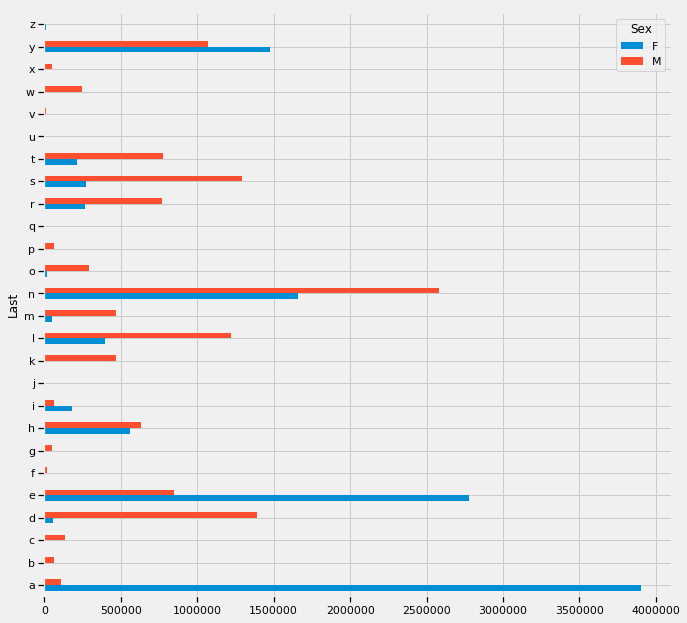

In [42]:
last_letter_pivot.plot.barh(figsize=(10, 10));

Try using `unstack` to switch between formats

In [47]:
letter_counts.unstack().head()

Count           
Sex           F          M
Last                      
a     3902939.0   110143.0
b        1271.0    62620.0
c         962.0   131376.0
d       59145.0  1389247.0
e     2779252.0   845460.0

Why is this still not ideal?

- Plotting raw counts
- Not sorted by any order

In [43]:
totals = last_letter_pivot['F'] + last_letter_pivot['M']

last_letter_props = pd.DataFrame({
    'F': last_letter_pivot['F'] / totals,
    'M': last_letter_pivot['M'] / totals,
}).sort_values('M')
last_letter_props.head()

,F,M
Last,,
a,0.972554,0.027446
e,0.766751,0.233249
i,0.748825,0.251175
z,0.737136,0.262864
y,0.579558,0.420442


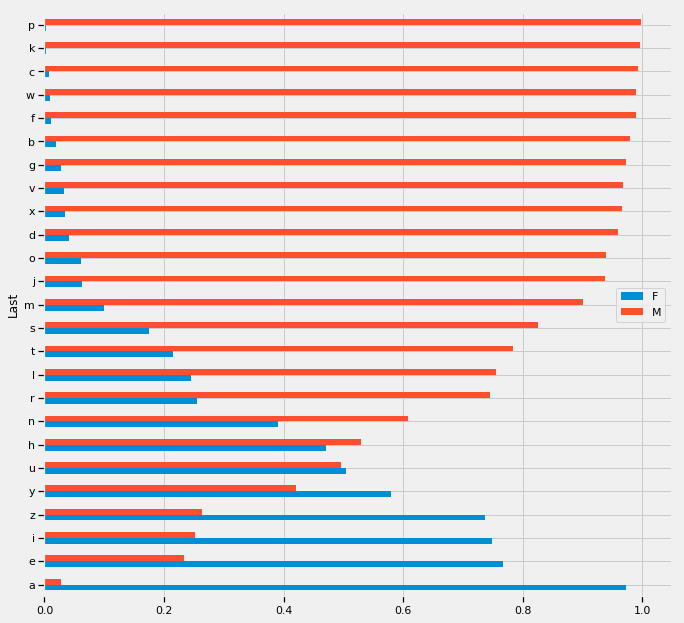

In [46]:
last_letter_props.dropna().plot.barh(figsize=(10, 10));

## Question

#### Can you predict gender from number of vowels?

In [53]:
def vowel_count(strInput):
    intOutput = 0 
    for char in 'aeiou':
        if (char in strInput):
            intOutput += 1
            
    return intOutput            

In [55]:
ny['Vowel'] = ny['Name'].apply(vowel_count)

In [56]:
ny.head()

,State,Sex,Year,Name,Count,Last,Vowel
0,NY,F,1910,Mary,1923,y,1
1,NY,F,1910,Helen,1290,n,1
2,NY,F,1910,Rose,990,e,2
3,NY,F,1910,Anna,951,a,1
4,NY,F,1910,Margaret,926,t,2


In [71]:
ny_vowel = (ny
         .loc[:, ('Sex', 'Count', 'Vowel')]
         .groupby(['Vowel', 'Sex'])
         .sum())
ny_vowel

Count
Vowel Sex         
0     F     141431
      M      16868
1     F    3141382
      M    4104846
2     F    5800948
      M    6750767
3     F    2485700
      M    1703043
4     F     285469
      M      34919
5     F        217

In [77]:
ny_vowel = ny.pivot_table(
    index='Vowel', # the rows (turned into index)
    columns='Sex', # the column values
    values='Count', # the field(s) to processed in each group
    aggfunc=sum, # group operation
)

In [79]:
totals = ny_vowel['F'] + ny_vowel['M']

vowel_props = pd.DataFrame({
    'F': ny_vowel['F'] / totals,
    'M': ny_vowel['M'] / totals,
}).sort_values('M')
vowel_props.head()

,F,M
Vowel,,
0,0.893442,0.106558
4,0.891010,0.108990
3,0.593424,0.406576
2,0.462164,0.537836
1,0.433520,0.566480


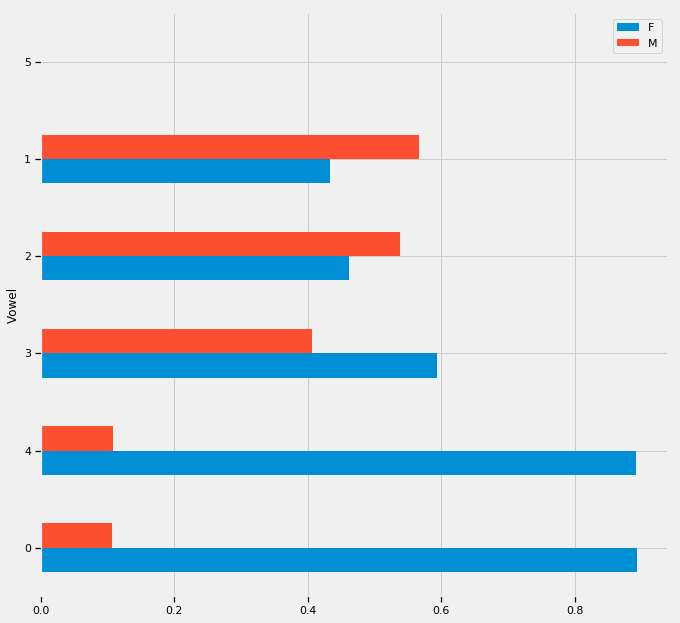

In [80]:
vowel_props.plot.barh(figsize=(10, 10));